# Compute Isothermal Spectra

We need to compute synthetic spectra and continuum for our full bandpass as a function of temperature 

In [29]:
import sys

import numpy as np
import astropy.units as u
import hissw
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
import asdf

import ndcube
from ndcube.extra_coords import QuantityTableCoordinate

sys.path.append('../../scripts/')
from response import Channel, SpectrogramChannel

In [2]:
chan = SpectrogramChannel(0, '../data/MOXSI_effarea.genx')

In [3]:
ssw = hissw.Environment(ssw_packages=['chianti'])

In [4]:
script = '''
ioneq_name = '{{ [ ssw_home, 'packages/chianti/dbase/ioneq', ioneq_file ] | join('/') }}'
abund_name = '{{ [ ssw_home, 'packages/chianti/dbase/abundance', abundance_file ] | join('/') }}'
wavelength = {{ wavelength | to_unit('Angstrom') | list }}
wave_min = wavelength[0]
wave_max = wavelength[-1]
log_temperature = {{ temperature | to_unit('K') | log10 }}
log_em = {{ emission_measure | to_unit('cm-5') | log10 }}
density = {{ density | to_unit('cm-3') }}

;generate transition structure for selected wavelength and temperature range
ch_synthetic, wave_min, wave_max, output=transitions,$
              ioneq_name=ioneq_name,$
              logt_isothermal=log_temperature,$
              logem_isothermal=log_em,$
              density=density[0]
              
;compute the spectra as a function of lambda and T
make_chianti_spec, transitions, wavelength, spectrum,$
                   abund_name=abund_name,$
                   /continuum,/lookup,/photons
'''

In [5]:
wavelength = chan.wavelength
temperature = 10**np.arange(5.5, 7.6, 0.1)*u.K
emission_measure = 1 * u.Unit('cm-5')
density = 1e15 * u.Unit('K cm-3') / temperature
ioneq_file = 'chianti.ioneq'
abundance_file = 'sun_coronal_1992_feldman.abund'

In [6]:
def get_isothermal_spectra(T, n):
    input_args = {
        'wavelength': wavelength,
        'temperature': T,
        'emission_measure': emission_measure
        'density': n,
        'ioneq_file': ioneq_file,
        'abundance_file': abundance_file,
    }
    output = ssw.run(script, args=input_args, save_vars=['spectrum'])
    spectrum = output['spectrum']['spectrum'][0]
    # The unit string from CHIANTI uses representations astropy
    # does not like so we fake those units
    u.add_enabled_units([
        u.def_unit('photons', represents=u.photon),
        u.def_unit('Angstroms', represents=u.Angstrom)
    ])
    spectrum_unit = u.Unit(output['spectrum']['units'][0][1].decode('utf-8'))
    spectrum = u.Quantity(spectrum, spectrum_unit)
    # Originally, the spectrum was computed assuming unit EM.
    # Divide through to get the units right
    spectrum = spectrum / emission_measure
    
    return spectrum.to('cm3 ph Angstrom-1 s-1 sr-1')

In [7]:
all_spectra = []
for t,n in zip(temperature, density):
    spec = get_isothermal_spectra(t,n)
    all_spectra.append(spec)
all_spectra = u.Quantity(all_spectra)

IDL 8.8.1 (linux x86_64 m64).
(c) 2021, Harris Geospatial Solutions, Inc.
% Error initializing graphics device GL.

Licensed for use by: NASA - Goddard Space Flight Center - MAIN
License: MNT-5527480
A new version is available: IDL 8.8.2
https://harrisgeospatial.flexnetoperations.com
 
% Compiled module: USE_CHIANTI.
% Compiled module: DIR_EXIST.
% DEVICELIB: Added system variable !BCOLOR
% DEVICELIB: Added system variable !ASPECT
% Compiled module: HISSW_PROCEDURE.
% Compiled module: CH_SYNTHETIC.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: DATATYPE.
% Compiled module: READ_IONEQ.
% Compiled module: READ_MASTERLIST.
% Compiled module: CONVERTNAME.
% Compiled module: STR_SEP.
% Compiled module: ION2SPECTROSCOPIC.
% Compiled module: ZION2FILENAME.
% Compiled module: SPLINE.
% Compiled module: CH_SETUP_ION.
% Compiled module: ION2FILENAME.
% Compiled module: READ_WGFA_STR.
% Compiled module: READ_ELVLC.
% Compiled module: ZION2SPECTROSCOPIC.
% Compiled module:

In [27]:
all_spectra.to('cm3 ph Angstrom-1 s-1 sr-1')

Unit("cm3 ph / (Angstrom s sr)")

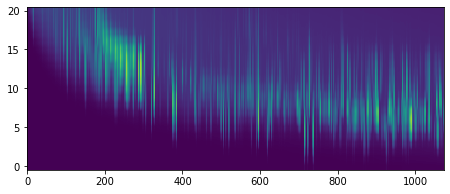

In [23]:
plt.figure(figsize=(12,3))
plt.imshow(all_spectra,aspect=20,origin='lower', norm=ImageNormalize(stretch=LogStretch()))

Figure out some way to serialize this to a file, maybe HDF5.
Put this all in a script, only run it when necessary

In [28]:
tree = {}
tree['temperature'] = temperature
tree['density'] = density
tree['wavelength'] = wavelength
tree['ioneq_filename'] = ioneq_file
tree['abundance_filename'] = abundance_file
tree['spectrum'] = all_spectra.to('cm3 ph Angstrom-1 s-1 sr-1')
with asdf.AsdfFile(tree) as asdf_file:
    asdf_file.write_to('spectral-table.asdf')

In [44]:
gwcs = (QuantityTableCoordinate(wavelength, physical_types='em.wl') & 
        QuantityTableCoordinate(temperature, physical_types='phys.temperature')).wcs
meta = {'ioneq': ioneq_file, 'abundance': abundance_file}
spec_cube = ndcube.NDCube(all_spectra.to('cm3 ph Angstrom-1 s-1 sr-1'), wcs=gwcs, meta=meta,)
spec_cube.extra_coords.add('density', (0,), density, physical_types='phys.density')

In [46]:
spec_cube

NDCube
------
Dimensions: [  21. 1073.] pix
Physical Types of Axes: [('phys.temperature', 'phys.density'), ('em.wl',)]
Unit: cm3 ph / (Angstrom s sr)
Data Type: float64

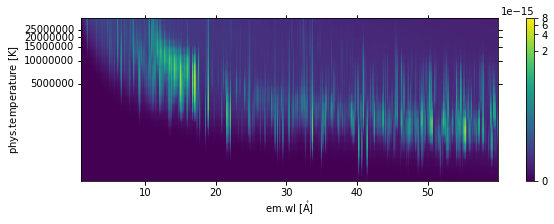

In [50]:
plt.figure(figsize=(10,3))
spec_cube.plot(aspect=20, norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()

In [ ]:
def read_spectral_table(filename):
    """
    Read a spectral table file and return an NDCube
    
    Parameters
    ----------
    filename : `str` or path-like
        Path to ASDF file containing 
    """
    # Read file
    with asdf.open(filename, mode='r', copy_arrays=True) as af:
        temperature = af['temperature']
        density = af['density']
        wavelength = af['wavelength']
        ioneq_filename = af['ioneq_filename']
        abundance_filename = af['abundance_filename']
        spectrum = af['spectrum']

    # Build cube
    gwcs = (
        QuantityTableCoordinate(wavelength, physical_types='em.wl') & 
        QuantityTableCoordinate(temperature, physical_types='phys.temperature')
    ).wcs
    meta = {
        'ioneq_filename': ioneq_filename,
        'abundance_filename': abundance_filename,
    }
    spec_cube = ndcube.NDCube(spectrum, wcs=gwcs, meta=meta)
    spec_cube.extra_coords.add('density', (0,), density, physical_types='phys.density')
    
    return spec_cube